In [114]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
words = open('names.txt', 'r').read().splitlines()

In [116]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [117]:
len(words)

32033

In [118]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [119]:
def buildDataset(words):
    block_size = 3
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join ([itos[i] for i in context]), '-->', itos[ix])
            context = context[1:] + [ix]
            
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y
import random
random.seed(42)
random.shuffle(words)
n1 = int (len(words)*.8)    
n2 = int (len(words)*.9)    
x_train, y_train = buildDataset(words[:n1])
x_val, y_val = buildDataset(words[n1:n2])
x_test, y_test = buildDataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [120]:
n_embd = 10
n_hidden = 200
block_size = 3

C = torch.randn(len(itos), n_embd)
W1 = torch.randn(n_embd * block_size, n_hidden) * (5/3)/(n_embd * block_size)**.5     #* .1
B1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn(n_hidden, len(itos)) * .01 # To initialize the weights to be closer together
B2 = torch.randn(len(itos)) * 0.01

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

params = [C, W1, B1, W2, B2, bngain, bnbias]
for p in params:
    p.requires_grad = True

In [123]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(x_train), (batch_size,))
    Xb = x_train[ix]
    Yb = y_train[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1
    bnmeani = hpreact.mean(0, keepdim= True)
    bnstdi = hpreact.std(0, keepdim= True)
    hpreact = bngain*(hpreact - bnmeani) / (bnstdi) + bnbias # Batch normalization, to avoid tanh saturation in an easier way
    
    with torch.no_grad():
        bnmean_running = .999 * bnmean_running + .001 * bnmeani
        bnstd_running = .999 * bnstd_running + .001 * bnstdi    
    
    h = hpreact.tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Yb)
    
    
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = .1
    for p in params:
        p.data -= lr * p.grad
    
        
    if i % 10000 == 0:
        print(i, loss.item())
        lr *= .98
    lossi.append(loss.log10().item())

0 2.75044322013855
10000 2.562368392944336
20000 1.8165065050125122
30000 1.9083325862884521
40000 2.020287275314331
50000 2.4933595657348633
60000 2.094913959503174
70000 2.2460134029388428
80000 1.85255765914917
90000 1.8773140907287598
100000 2.555894136428833
110000 2.1720573902130127
120000 2.0871455669403076
130000 1.9637221097946167
140000 2.0497541427612305
150000 2.2560431957244873
160000 2.6535260677337646
170000 1.8429242372512817
180000 2.306605339050293
190000 1.8388421535491943


In [124]:
-torch.tensor(1/27.0).log() # expected initial loss, but it is 27 right now because the initial probabilities are not uniform

tensor(3.2958)

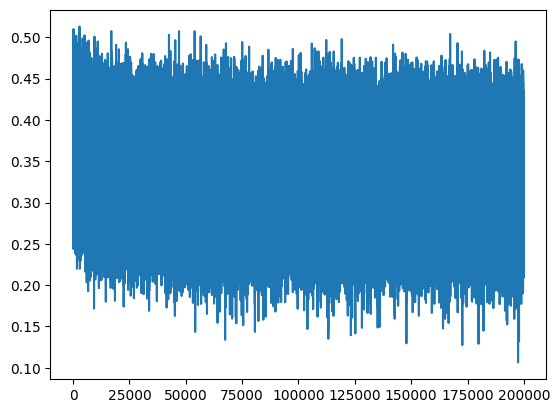

In [125]:
plt.plot(lossi)

In [126]:
with torch.no_grad():
    emb = C[x_train]
    embcat = emb.view(emb.size(0), -1)
    hpreact = embcat @ W1 + B1
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0, keepdim= True)

In [127]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.size(0), -1)
    hpreact = embcat @ W1 + B1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.1127567291259766
val 2.1549293994903564


initial losses after changing the initialization
train 2.180690050125122
val 2.2376396656036377

loss after fixing tanh activation
train 2.1318764686584473
val 2.1838724613189697

After batch norm
train 2.126826286315918
val 2.1739890575408936